In [13]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [14]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 48                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 256                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')
# input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp'
year      = [1958, 2019]
mon       = None
day       = None
record    = None 
box       = None
depth     = None

# #___Define Reference Data, Year, Mon ...______________________________________________
# # do anomaly plots in case ref_path is not None
# ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
# ref_name  = None # 'TKE'
# ref_year  = None #[1979, 2019]
# ref_mon   = None
# ref_day   = None
# ref_record= None

#___Define Boxregion via shape file for index compuation_______________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

# ref_cstr  = 'wbgyr'
# ref_cnum  = 15
# ref_cref  = None
# ref_crange= None
# ref_cmin  = None
# ref_cmax  = None
# ref_cfac  = None
# ref_climit= None
# ref_chist = True
# ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [15]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem)

No existing Dask cluster found at: tcp://0.0.0.0:0000
Dask client already running: <Client: 'tcp://127.0.0.1:34477' processes=48 threads=48, memory=238.40 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270042/levante-spawner-preset//proxy/42113/status,
Dashboard: /user/a270042/levante-spawner-preset//proxy/42113/status,Workers: 48
Total threads: 48,Total memory: 238.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34477,Workers: 48
Dashboard: /user/a270042/levante-spawner-preset//proxy/42113/status,Total threads: 48
Started: 44 minutes ago,Total memory: 238.40 GiB
Comm: tcp://127.0.0.1:42067,Total threads: 1
Dashboard: /user/a270042/levante-spawner-preset//proxy/43965/status,Memory: 4.97 GiB
Nanny: tcp://127.0.0.1:38845,


In [16]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, _ , _ = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, None, None, n_cycl, do_allcycl)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path != None): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
# #______________________________________________________________________________________________________    
# # concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
# input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 'auto', 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : 'auto', 
               'nz'   : 'auto',
               'edg_n': 'auto'}) 

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /home/a/a270042/meshcache_tripyview/dart
 > load  *.jlib file: tripyview_fesom2_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /work/ba1264/a270210/model/input/fesom2/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 80
___________________________________________
global


In [17]:
#___LOAD CLIMATOLOGY___________________________________________________________________________________
clim_vname = vname
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname): 
    # load climatology and interpolate to fesom grid 
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    ts = clock.time()
    clim      = tpv.load_climatology(mesh, clim_path, clim_vname, do_load=False, do_persist=False)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    
    # create hovmoeller from clim
    ts = clock.time()
    clim_hovm = tpv.load_index_fesom2(mesh, clim, box, do_harithm='wmean')
    print(' --> elasped time to comp. clim hovm.: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    for ii, data_ii in enumerate(clim_hovm):
        print(' --> clim_hovm[{:s}] uses {:3.2f} Mb:'.format(clim_hovm[ii][list(clim_hovm[ii].keys())[0]].attrs['boxname'], clim_hovm[ii].nbytes/(1024**2)))
    
    del(clim)
    print('')
else: raise ValueError('climatology not supported for choosen vname')    

#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list     = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 10 # -> you can use larger chunks here if you have enough memory, for dart/D3 up to 10yr was working
chnk_yrs_list = year_list[::chnk_size]
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(datapath, descript)
    print(' > year:', end='')
    ts = clock.time()
    
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
        #__________________________________________________________________________________________________
        # load fesom2 data
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year_chnk, mon=mon,  descript=descript, chunks=chunks, 
                                     do_tarithm='None', do_zarithm='None', do_info=False, do_load=False, do_persist=False, 
                                     do_parallel=do_parallel)
        #__________________________________________________________________________________________________    
        # check if data where loaded
        if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
        # print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
        # print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
        
        #__________________________________________________________________________________________________
        # create hovmoeller from data
        data_hovm_chnk = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean')
        del(data)
    
        # compute anomalous hovmoeller with respect to climatology
        data_hovm_chnk = tpv.do_indexanomaly(data_hovm_chnk, clim_hovm)

        #__________________________________________________________________________________________________
        # concatenate time chunks together
        if nchnk==0: data_hovm = data_hovm_chnk
        else       : 
            for ii in range(0,len(box)):
                data_hovm[ii] = xr.concat([data_hovm[ii], data_hovm_chnk[ii]], dim='time')
        del(data_hovm_chnk)
        
    #______________________________________________________________________________________________________
    print(' --> elasped time to comp. data hovm.: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    for ii, data_ii in enumerate(data_hovm):
        print(' --> data_hovm[{:s}] uses {:3.2f} Mb:'.format(data_hovm[ii][list(data_hovm[ii].keys())[0]].attrs['boxname'], data_hovm[ii].nbytes/(1024**2)))

    #______________________________________________________________________________________________________
    data_list.append(data_hovm)
    del(data_hovm)

['salt']
 --> elasped time to load clim: 0.08 min.
 --> clim uses 1.90 Gb:
 --> elasped time to comp. clim hovm.: 0.09 min.
 --> clim_hovm[global] uses 0.00 Mb:

/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/ Tido Test
 > year:1958|1959|1960|1961|1962|1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972|1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982|1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992|1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002|2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012|2013|2014
         --> elasped time to comp. data hovm.: 5.97 min.
 --> data_hovm[global] uses 0.21 Mb:


--> histo: cmin, cmax =  -1.2689588069915771 0.6394451856613159
{'cstr': 'blue2red', 'cnum': 15, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -1.27, 'cmax': 0.64, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ffe60652920>, 'clevel': array([-1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3,
       -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]), 'clab': array([-1.2, -0.9, -0.6, -0.3,  0. ,  0.3,  0.6])}


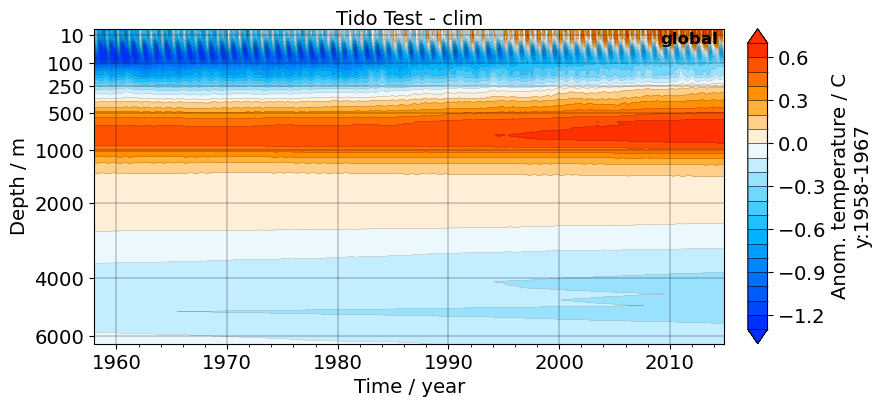

In [18]:
#___PLOT HOVM__________________________________________________________________________________________
ts = clock.time()
nbox, ndat = len(box), len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
for box_idx in range(nbox):
    svname = list(data_list[-1][box_idx].data_vars)[0]
    slabel = data_list[-1][box_idx][svname].attrs['str_lsave']
    sbox   = data_list[-1][box_idx][svname].attrs['boxname'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'hovmclim', sbox ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
      
    #__________________________________________________________________________________________________
    # do colorbar either single cbar or ref_cbar + anom_cbar
    cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
    #__________________________________________________________________________________________________    
    hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=nrow0, ncol=ncol0, box_idx=box_idx, 
                                     cinfo=cinfo0, 
                                     do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                     ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                     cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                     do_save=sfpath, save_dpi=save_dpi )    

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))

In [19]:
if do_papermill and do_parallel and client is not None: client.shutdown()